# Statistical Comparisons Generator

This notebook separates different measurement categories into numerous populations and compares the statistical significance of data trends

In [1]:
#all package imports needed for notebook here
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import seaborn as sns
import numpy as np
import pprint as pp
from datetime import datetime
from IPython.display import display

df2013 = pd.read_csv('Kwadella_winter_2013_cleaned.csv')
df2014 = pd.read_csv('Kwadella_winter_2014_cleaned.csv')

/home/mackenzie/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/mackenzie/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


First we're looking at an analysis of variance between 2014 and 2013 to see how significantly the years differed. We'll look at how the outdoor temperatures varied (as a soft control), then compare the year's pollutant concentrations  to get a read for how well the intervention reduced pollution. We'll do this again with diurnal plots to be sure. 

Cross correlation will let us track dusttraks vs PM2.5 vs PM10 vs CO concentrations and traking the rise and fall of each pollutant over the course of the entire winter. We're starting by just looking at the entire winter, then we may divide pollution measurements based on temperature deviation of a given day or by month

Kruskal is best for comparing one category of measurement at different time points to see if there is significant variance between those groups. for example:  Krusal done on dusttraks from the mean temp track, dusttraks from 1 sd colder than the mean, and dusttraks from 1 sd warmer than the mean. This measurement would tell us if there is variance in pollution between the three groups. This test could also be applied to 2013 vs 2014 dusttraks to find statistical significance in the differences in pollution before and after intervention

In [2]:
def get_datetime(s):
    """strips date and time from the already existing date column"""
    dt = datetime.strptime(s, "%m/%d/%y %H:%M")
    return dt

def daysSinceStart(df):
    """get time since epoch using a series for month and day
    takes in dataframe and returns the dataframe with an added colum for days since the beginning of data collection"""
    dayArray = np.array(df.Day)
    monthArray = np.array(df.Month)
    
    runningDays = []
    for day, month in zip(dayArray, monthArray):
        if month == 7:
            total_days = 0
        elif month == 8:
            total_days = 31 
        elif month == 9:
            total_days = 61
        else:
            raise ValueError 
        total_days = total_days + day
        runningDays.append(total_days)
    df['DayCount'] = pd.Series(runningDays, index = df.index)
    return df

#Daily Average Outdoor Temp
def compute_avg_temp(df):
    df['DailyAverageTemp'] = df['Temperature_(degC)'].mean()
    return df

#each minute's avg indoor temp
def compute_avg_house13(df):
    """tailored to compute the average indoor house temperature of 2013"""
    df['AvgHouse'] = (df['H01-K-E']+ df['H02-K-N']+ df['H03-K-S']+ df['H04-K-S']
                      + df['H05-K-N']+df['H06-K-N'] + df['H10-K-N']
                      +df['H11-K-X']+ df['H12-K-N'] + df['H15-K-S'] +df['H17-K-N'] 
                      + df['H18-K-S'] + df['H20-K-S']
                      )/13
    return df

def compute_avg_house14(df):
    """tailored to compute the avg indoor house temp for 2014"""
    df['AvgHouse'] = (df['H01-K-E']+ df['H02-K-N']+ df['H03-K-S']+ df['H04-K-S']
                      + df['H05-K-N']+df['H06-K-N'] + df['H10-K-N']
                      +df['H11-K-N'] + df['H15-K-N']+df['H16-K-N'] +df['H17-K-S'] 
                      + df['H18-K-N']+df['H19-K-W'] + df['H22-K-S']
                      )/14
    return df

def preprocess(df):
    """runs the datetime and daysSinceStart helper functions
    takes and returns a dataframe"""
    res = df.copy()
    datetimes = res.Date.apply(get_datetime)
    res['Hour'] = datetimes.apply(lambda dt: dt.hour)
    res['Day'] = datetimes.apply(lambda dt: dt.day)
    res['Month'] = datetimes.apply(lambda dt: dt.month)
    res['Year'] = datetimes.apply(lambda dt: dt.year)
    return res

In [3]:
df2013 = preprocess(df2013)
df2013 = daysSinceStart(df2013)
grouped = df2013.groupby('DayCount')
df2013 = grouped.apply(compute_avg_temp)
df2013 = compute_avg_temp(df2013)
df2013 = compute_avg_house13(df2013)
df2013['Dusttraks_(mg/m3)']= df2013['Dusttraks_(mg/m3)']*0.14


df2014 = daysSinceStart(df2014)
grouped = df2014.groupby('DayCount')
df2014 = grouped.apply(compute_avg_temp)
df2014 = compute_avg_temp(df2014)
df2014 = compute_avg_house14(df2014)
df2014['Dusttraks_(mg/m3)']= df2014['Dusttraks_(mg/m3)']*0.14

In [4]:
df2014.AvgHouse.describe()

count    96501.000000
mean        18.408246
std          4.213109
min          7.900000
25%         15.085714
50%         18.642857
75%         21.278571
max         30.578571
Name: AvgHouse, dtype: float64

 the normalize function literally normalizes a dataframe, you just have to be careful you give it only columns with integers that you want to normalize together(ie don't give it DayCounts or another time/date indicator). 

A large chunk of our data is nan, to the point where it's actually a bad idea to drop nans and filling any in won't give us meaningful data.We found out that pandas actually does a pretty good job just ignoring nans when performing operations, so we actually stayed away from using numpy and scipy for all the following operations, and stuck to pandas methods.

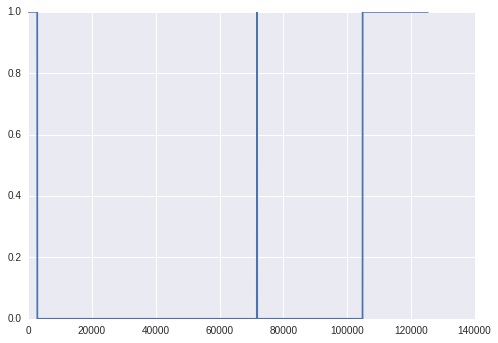

In [5]:
def normalize(df, headers):
    """Normalizes values of a dataframe after filling missing values- see FillMissing
    df: dataframe of un-normalized integer only data
    headers: specifc columns to be compared to one another
    returns: now normalized dataframe of only the specified headers with missing values filled in"""
    normdf = df[headers]
    df_norm = (normdf-normdf.mean())/(normdf.max() - normdf.min())
    return df_norm

intHeadCorrList= [ 'Temperature_(degC)','Dusttraks_(mg/m3)', 'PM10_(ug/m3)','PM2.5_(ug/m3)','SO2_(ppb)','CO_(ppm)','NO_(ppb)',
                 'NO2_(ppb)','AvgHouse']
plt.plot(df2013[intHeadCorrList[0:1]].isnull().mean(axis=1))
dfnorm13 = normalize(df2013, intHeadCorrList)

We chose a spearman correlation because it doesn't rely on the parameters a perason's correlation does. The pandas methof dataframe.corr let us pick spearman, ignores nans (a must have) and constructs a useful dataframe of correlation coefficients that just make the whole matrix process a lot less painful.

In [6]:
speardf = dfnorm13.corr(method = 'spearman')
print speardf.head()

                    Temperature_(degC)  Dusttraks_(mg/m3)  PM10_(ug/m3)  \
Temperature_(degC)            1.000000           0.025234      0.320008   
Dusttraks_(mg/m3)             0.025234           1.000000      0.388485   
PM10_(ug/m3)                  0.320008           0.388485      1.000000   
PM2.5_(ug/m3)                 0.012230           0.349414      0.353744   
SO2_(ppb)                     0.375853           0.280002      0.455247   

                    PM2.5_(ug/m3)  SO2_(ppb)  CO_(ppm)  NO_(ppb)  NO2_(ppb)  \
Temperature_(degC)       0.012230   0.375853 -0.252044  0.083755   0.172606   
Dusttraks_(mg/m3)        0.349414   0.280002  0.137353  0.389796   0.278899   
PM10_(ug/m3)             0.353744   0.455247  0.217672  0.268485   0.454548   
PM2.5_(ug/m3)            1.000000   0.162776  0.310283  0.146666   0.291135   
SO2_(ppb)                0.162776   1.000000  0.282189  0.517021   0.717334   

                    AvgHouse  
Temperature_(degC)  0.770790  
Dusttraks_(m

In [7]:
def correlationHeatmap(corrmat, year = ''):
    """Constructs a heatmap correlation matrix
    corrmat: dataframe of correlation constants
    year: year to which data applies"""
#set up mask to cover upper triangle of the matrix 
    mask = np.zeros_like(speardf, dtype=np.bool)
    mask[np.triu_indices_from(mask, k=1)] = True

# Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
    sns.heatmap(corrmat,mask=mask, vmax=.8, square=True)

    plt.title('Winter of '+ year+ ' Temperature and Pollutant Correlations')
    plt.xticks(rotation=30)
    f.tight_layout()

This code for a cross correlation heatmap taken from some helpful seaborn documentation from stanford: https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.heatmap.html

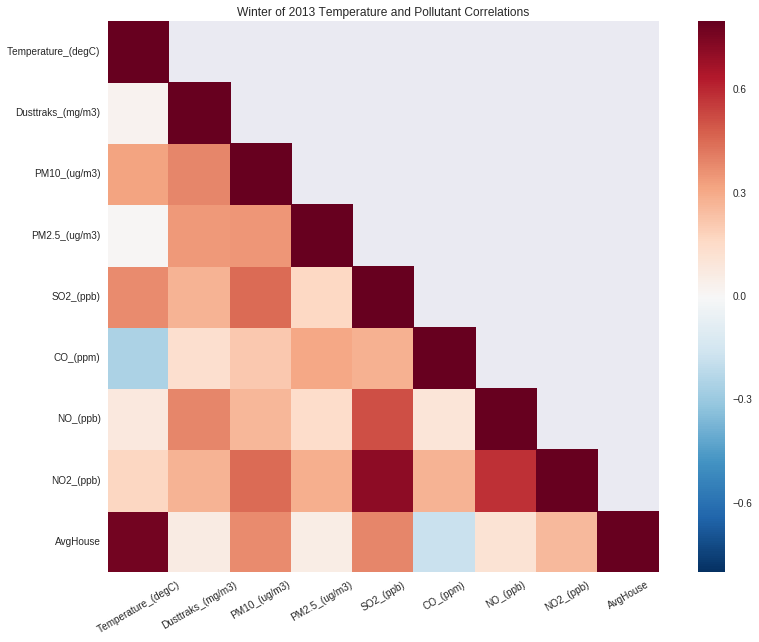

In [8]:
correlationHeatmap(speardf, '2013')

Do this with 2014, cold, warm, hot, and diurnal profiles

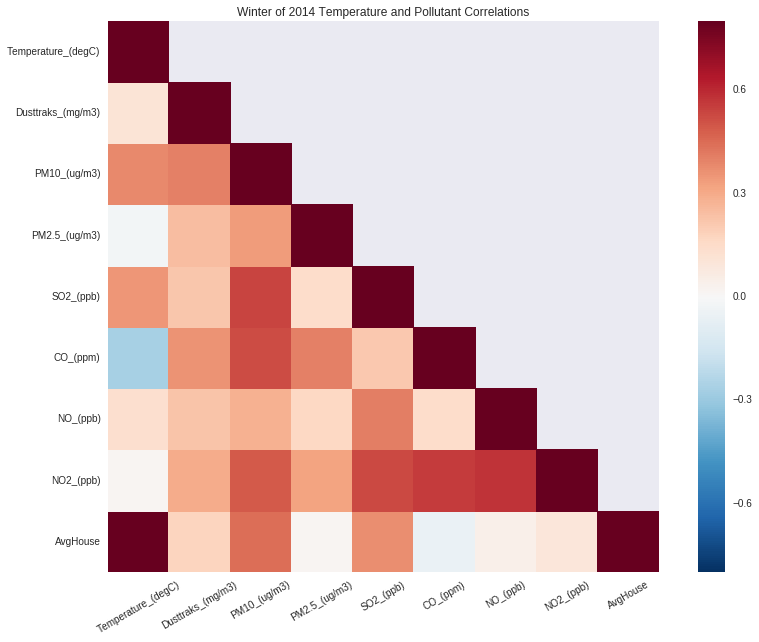

In [9]:
dfnorm14 = normalize(df2014, intHeadCorrList)
speardf14 = dfnorm14.corr(method = 'spearman')
correlationHeatmap(speardf14, '2014')

Now I'm trying to look at the difference between quartiles

In [15]:
def getwarmdf(df):
    tempstd = df['DailyAverageTemp'].std()
    tempmean = df['DailyAverageTemp'].mean()
    warmdf = df[df['DailyAverageTemp'] >= tempmean+tempstd]
    return warmdf
def getmiddf(df):
    tempstd = df['DailyAverageTemp'].std()
    tempmean=df['DailyAverageTemp'].mean()
    middf = df[df['DailyAverageTemp']>= tempmean - tempstd]
    middf = middf[df['DailyAverageTemp'] < tempmean+tempstd]
    return middf
def getcolddf(df):
    tempstd = df['DailyAverageTemp'].std()
    tempmean = df['DailyAverageTemp'].mean()
    colddf = df[df['DailyAverageTemp'] < tempmean - tempstd]
    return colddf
dfwarm13 = getwarmdf(df2013)
dfmid13 = getmiddf(df2013)
dfcold13 = getcolddf(df2013)

dfwarm14 = getwarmdf(df2014)
dfmidtemp14 = getmiddf(df2014)
dfcold14 = getcolddf(df2014)

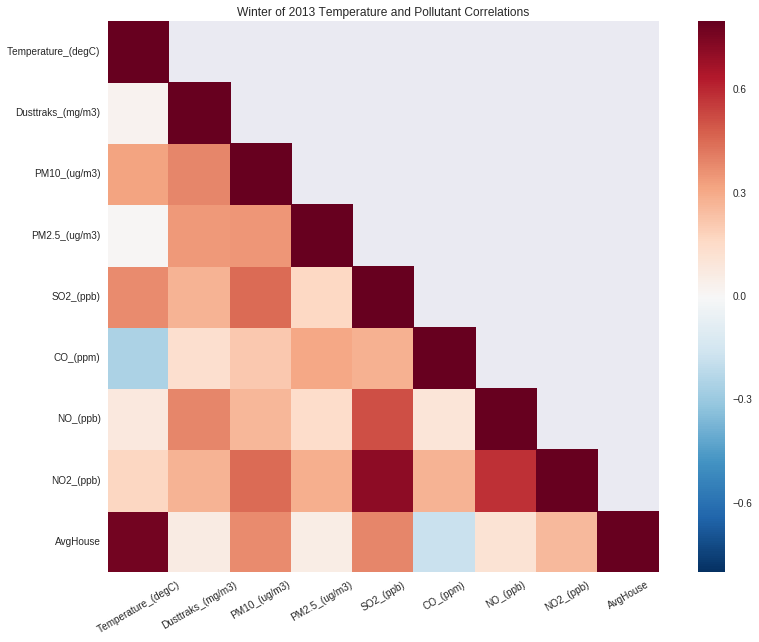

In [12]:
dfnormwarm13 = normalize(dfwarm13, intHeadCorrList)
speardfwarm13 = dfnormwarm13.corr(method = 'spearman')
correlationHeatmap(speardfwarm13, '2013')

ValueError: zero-size array to reduction operation minimum which has no identity

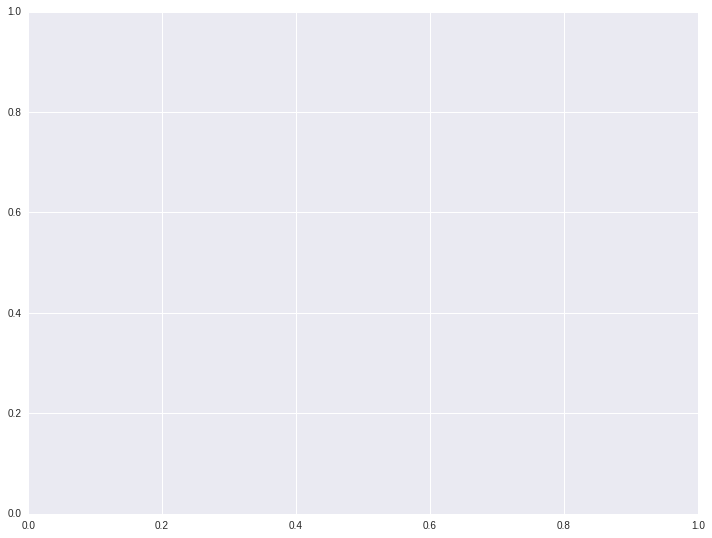

In [13]:
dfnormcold13 = normalize(dfcold13, intHeadCorrList)
speardfcold13 = dfnormcold13.corr(method = 'spearman')
correlationHeatmap(speardfcold13, '2013')

ValueError: zero-size array to reduction operation minimum which has no identity

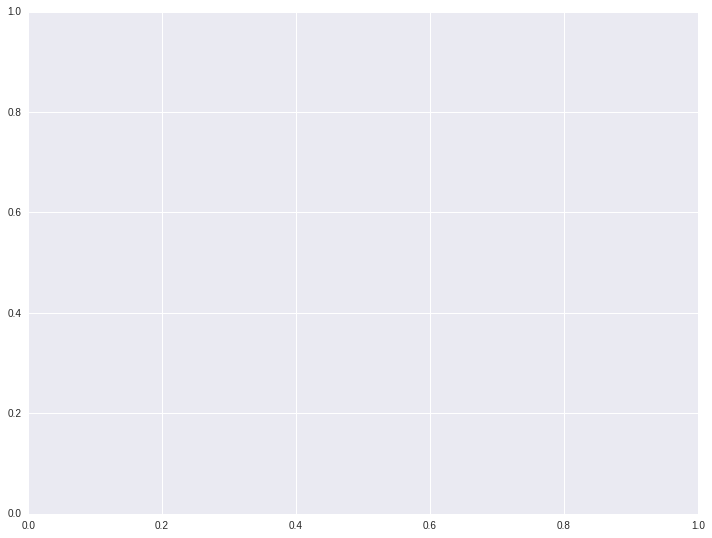

In [16]:
dfnormmid13 = normalize(dfmid13, intHeadCorrList)
speardfmid13 = dfnormmid13.corr(method = 'spearman')
correlationHeatmap(speardfmid13, '2013')